In [40]:
import pandas as pd
import numpy as np


In [41]:
df=pd.read_csv('MaunaLoaDailyTemps.csv',index_col='DATE',parse_dates=True)
df=df.dropna()
print('shape of data',df.shape)
df.head()

shape of data (1821, 5)


,MinTemp,MaxTemp,AvgTemp,Sunrise,Sunset
DATE,,,,,
2014-01-01,33.0,46.0,40.0,657,1756
2014-01-02,35.0,50.0,43.0,657,1756
2014-01-03,36.0,45.0,41.0,657,1757
2014-01-04,32.0,41.0,37.0,658,1757
2014-01-05,24.0,38.0,31.0,658,1758


<AxesSubplot: xlabel='DATE'>

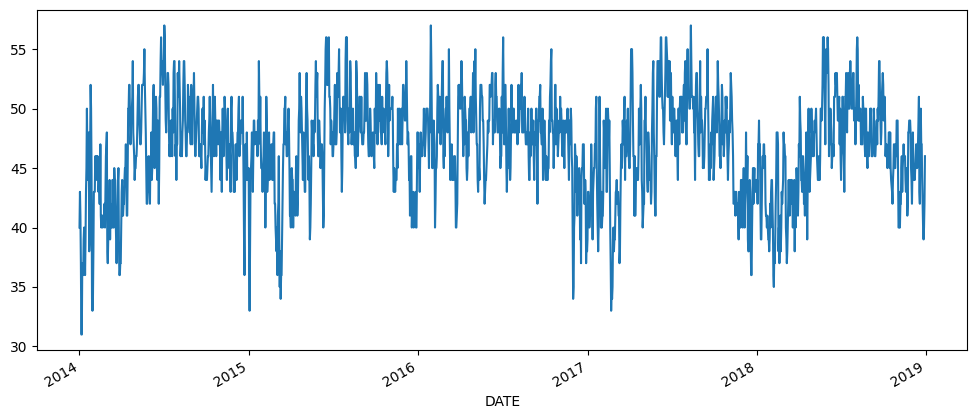

In [42]:
df['AvgTemp'].plot(figsize=(12,5))

here df test is an array of values

In [43]:
from statsmodels.tsa.stattools import adfuller
# Augmented Dickey-Fuller
def adf_test(dataset):
  dftest = adfuller(dataset, autolag = 'AIC')
  print("1. ADF : ",dftest[0])
  print("2. P-Value : ", dftest[1])
  print("3. Num Of Lags : ", dftest[2])
  print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
  print("5. Critical Values :")
  for key, val in dftest[4].items():
      print("\t",key, ": ", val)

In [44]:
# calling the test on avg temp
adf_test(df['AvgTemp'])
# here in output p(probability) val determines that if data is stationary or not...smaller the p val more stationary data is larger the p val less stationary data is
#  If the p-value is less than a significance level (e.g. 0.05), then the null hypothesis can be rejected and the time series is considered stationary.(precisely)
# n this data p value is very small so data is 

1. ADF :  -6.554680125068785
2. P-Value :  8.675937480199322e-09
3. Num Of Lags :  12
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 1808
5. Critical Values :
	 1% :  -3.433972018026501
	 5% :  -2.8631399192826676
	 10% :  -2.5676217442756872


FIGURING OUT THE ORDER FOR ARIMA MODEL 
this helps to accurately fit the time series data and make accurate forecasts

ARIMA (AutoRegressive Integrated Moving Average) is a statistical model used for time series analysis and forecasting. It is a combination of

AR(auto regression)
- uses pvs values to make future predictions.

MA(moving avg)
- uses past errors to make future predictions

I(integrated)differencing 
- which makes the time series stationary by removing the trend and seasonality.
- if data is not stationary that means let's say it data have inc trend or it has dec trend you basically difference it with previous vals to elimanate that trend

NOTE: 
- The parameters of the ARIMA model are the order of differencing (d), the order of autoregression (p), and the order of moving average (q). The model is specified as ARIMA(p,d,q).
- The model requires selecting the appropriate values of p, d, and q which can be done using statistical tests or trial and error. The ARIMA model can be used to make point or interval forecasts for the future values of a time series.

In [45]:
from pmdarima import auto_arima
# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

In [46]:
stepwise_fit = auto_arima(df['AvgTemp'], 
                          suppress_warnings=True)           

stepwise_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1821
Model:               SARIMAX(1, 0, 5)   Log Likelihood               -4139.134
Date:                Wed, 01 Feb 2023   AIC                           8294.268
Time:                        23:12:39   BIC                           8338.325
Sample:                             0   HQIC                          8310.522
                               - 1821                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.1617      0.352      3.296      0.001       0.471       1.852
ar.L1          0.9751      0.008    128.504      0.000       0.960       0.990
ma.L1         -0.1285      0.024     -5.448      0.000      -0.175      -0.082
ma.L2         -0.2208      0.024     -9.194      0.000      -0.268      -0.174
ma.L3         -0.2032      0.024     -8.523      0.000      -0.250      -0.156
ma.L4         -0.1377      0.023     -6.055      0.000      -0.182      -0.093
ma.L5         -0.0510      0.024     -2.092      0.036      -0.099      -0.003
sigma2         5.4988      0.172     31.947      0.000       5.161       5.836
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                19.95
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               0.81   Skew:                            -0.17
Prob(H) (two-sided):                  0.01   Kurtosis:                         3.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [47]:
from statsmodels.tsa.arima.model import ARIMA

#Split Data into Training and Testing set to evaluate performance of test and helps ensure that the model is a good fit for the time series data.

TRAINING SET
- The training set is used to fit the ARIMA model and estimate its parameters (p, d, q).
eg.  let's suppose you have dataset of 7500 entries then 7000 will go in training set and 500 entries will go in testing set  

TESTING SET
- The testing set is then used to evaluate how well the model generalizes to new data and make predictions.
- Comparing the predicted values to the actual values in the testing set gives us an estimate of the model's accuracy and helps us determine if the model is overfitting or underfitting the data.

In [48]:
 print(df.shape)
 train=df.iloc[:-30]
 test=df.iloc[-30:]
 print(train.shape,test.shape)

(1821, 5)
(1791, 5) (30, 5)


# Train the model on train set

In [49]:
model=ARIMA(train['AvgTemp'],order=(1,0,5))
model=model.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                AvgTemp   No. Observations:                 1791
Model:                 ARIMA(1, 0, 5)   Log Likelihood               -4070.198
Date:                Wed, 01 Feb 2023   AIC                           8156.395
Time:                        23:12:40   BIC                           8200.320
Sample:                             0   HQIC                          8172.614
                               - 1791                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         46.5856      0.758     61.454      0.000      45.100      48.071
ar.L1          0.9856      0.005    188.230      0.000       0.975       0.996
ma.L1         -0.1412      0.023     -6.124      0.000      -0.186      -0.096
ma.L2         -0.2268      0.024     -9.635      0.000      -0.273      -0.181
ma.L3         -0.2168      0.023     -9.251      0.000      -0.263      -0.171
ma.L4         -0.1479      0.023     -6.491      0.000      -0.193      -0.103
ma.L5         -0.0595      0.024     -2.438      0.015      -0.107      -0.012
sigma2         5.5093      0.174     31.624      0.000       5.168       5.851
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                14.88
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               0.82   Skew:                            -0.15
Prob(H) (two-sided):                  0.01   Kurtosis:                         3.33
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# make predictions on test set

In [50]:
start=len(train) #starts from train set ends
end=len(train)+len(test)-1  #ends at length of dataset-1
#if the predicted values dont have date values as index, you will have to uncomment the following two commented lines to plot a 

index_future_dates=pd.date_range(start='2018-12-01',end='2018-12-30')

# model.predict used to predict in training set
pred=model.predict(start=start,end=end,typ='levels').rename('ARIMA predictions')
pred.index=index_future_dates

pred.head()


2018-12-01    44.754109
2018-12-02    44.987795
2018-12-03    45.388741
2018-12-04    45.721546
2018-12-05    45.863733
Freq: D, Name: ARIMA predictions, dtype: float64

<AxesSubplot: xlabel='DATE'>

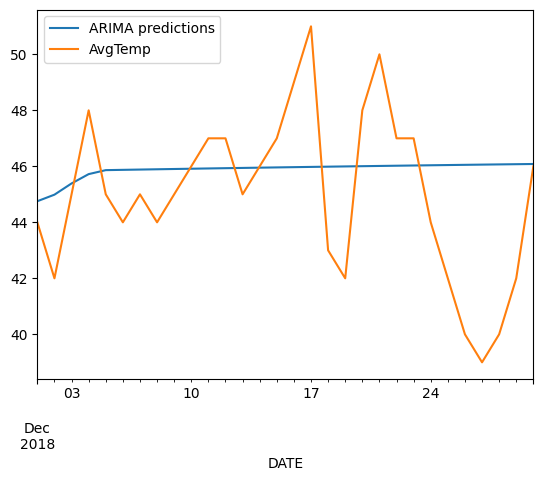

In [51]:
pred.plot(legend='ARIMA Predictions')
test['AvgTemp'].plot(legend=True)

- to see how efficient predictions is on training data set we calculate mean of test dataset and root mean square error(rmse) of pred and test data set.
- if rmse val is wayyy small than mean value than mean then it is acceptable or else not

In [52]:
test['AvgTemp'].mean()

45.0

In [53]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse=sqrt(mean_squared_error(pred,test['AvgTemp']))
print(rmse)

3.0004640041287756


- predictions on future values

In [54]:
model2=ARIMA(df['AvgTemp'],order=(1,0,5))
model2=model2.fit()
df.tail()

,MinTemp,MaxTemp,AvgTemp,Sunrise,Sunset
DATE,,,,,
2018-12-26,35.0,45.0,40.0,654,1752
2018-12-27,33.0,44.0,39.0,655,1752
2018-12-28,33.0,47.0,40.0,655,1753
2018-12-29,36.0,47.0,42.0,655,1753
2018-12-30,39.0,52.0,46.0,656,1754


In [55]:
# predictions upto 30 march 2019
index_future_dates=pd.date_range(start='2018-12-30',end='2019-03-30')
#print(index_future_dates)
pred=model2.predict(start=len(df),end=len(df)+90,typ='levels').rename('ARIMA Predictions')
#print(comp_pred)
pred.index=index_future_dates
print(pred)

2018-12-30    46.418166
2018-12-31    46.113912
2019-01-01    45.617874
2019-01-02    45.249566
2019-01-03    45.116915
                ...    
2019-03-26    46.083938
2019-03-27    46.090158
2019-03-28    46.096290
2019-03-29    46.102337
2019-03-30    46.108299
Freq: D, Name: ARIMA Predictions, Length: 91, dtype: float64


<AxesSubplot: >

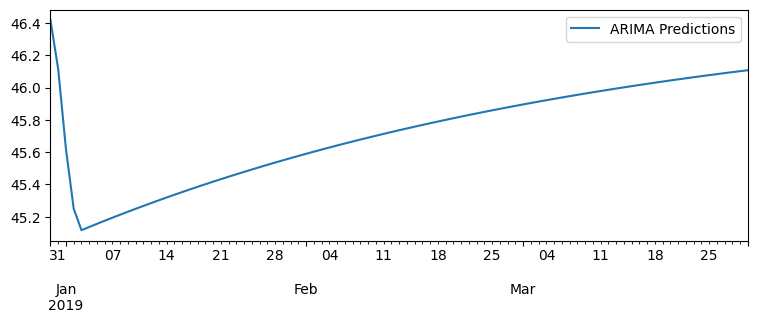

In [56]:
pred.plot(figsize=(9,3),legend=True)
